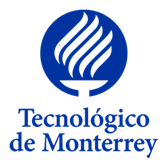

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 5

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Evaluando la Base de Conocimiento y el Modelo Fundacional con RAGAs y el Modelo a la Medida**

<img src="./Proyecto Integrador - RAG con Bedrock-Evaluation - Smart Travel Assistant KB v2.00 LangChain.drawio.png" alt="RAG Bedrock KB V1.00" />

A continuación se describe el proceso para evaluar las preguntas de referencia usando RAGAs y el modelo a la medida usado para evaluar preguntas y respuestas sintéticas:
1. Pasar cada una de las preguntas por el modelo generativo con la nueva base de conocimiento KB V2.00
2. Pasar cada una de las preguntas, las respuestas y contextos generados y las respuestas de referencia a RAGAs para su evaluación

## **Probando la Base de Conocimiento y el Modelo Fundacional**

### **Preparando el Ambiente de Ejecución**

Es necesario importar las librerías necesarias para iniciar una sesión de AWS y para registrar una bitácora de ejecución.

In [1]:
!pip install openpyxl

In [2]:
!pip install python-dotenv

In [3]:
!pip install langchain

In [4]:
!pip install langchain-community

In [5]:
!pip install langchain-text-splitters

In [6]:
!pip install langchain-aws

In [7]:
!pip install datasets

In [8]:
!pip install ragas

In [9]:
# Importando librerias requeridas
import time
import re
import json
import uuid
import io
import os
import logging

from dotenv import load_dotenv
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import boto3
import openpyxl

from langchain_community.retrievers import AmazonKnowledgeBasesRetriever
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_aws import BedrockLLM

from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    answer_similarity,
    context_precision,
)


In [10]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
#logging.basicConfig(
#    filename='../logs/Avance4_Equipo37_Bedrock_Alternative.log',
#    level=logging.INFO,
#    format='%(asctime)s %(levelname)-8s %(message)s',
#    datefmt='%Y-%m-%d %H:%M:%S'
#)

In [11]:
# Configurando constantes para la ejecución. AWS_KBID_Vxxx contiene el identificador de la base
# de conocimientos de AWS Bedrock
load_dotenv()
MAX_ENTRIES = 100
AWS_KBID_V200 = os.environ['AWS_KBID_V200']
PINECONE_API_KEY_V200 = os.environ['PINECONE_API_KEY_V200']
INDEX_V200 = 'volindov200'
KB_VERSION = '2.00'
SOURCE_AWS_BUCKET = 'volindo-hotel-data'
TARGET_DATA_FILE = f'hotel-clean-data-set/synthetic-data/hotel-data-set-selected-results.xlsx'


### **Creando Agente para Recuperar Informacion de Contexto**

In [12]:
# Creando sesion para AWS Bedrock. Credenciales y configuracion se obtienen de ~/.aws
retriever = AmazonKnowledgeBasesRetriever(
    knowledge_base_id=AWS_KBID_V200,
    retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 5}},
)

### **Creando Agente para Questionar el Modelo Fundacional**

In [13]:
model_kwargs_premier = {'temperature': 0, 'topP': 0.7, 'maxTokenCount': 3000}
llm = BedrockLLM(model_id='amazon.titan-text-premier-v1:0', model_kwargs=model_kwargs_premier)

### **Creando Función para Solictar Respuestas de AWS Bedrock y para Desplegarlas**

In [14]:
# Creando función para buscar información en la base de conocimiento y generar una respuesta usando el modelo fundacional
# Titan Text Premier de AWS Bedrock. La función también calcula el tiempo de ejecución
def retrieve_and_generate(query, retriever, llm):
    start_time = time.time()
    system_prompt = (
        "You are a friendly and helpful travel assistant. Begin your response with a polite greeting. Accurately use the detailed context provided from the database "
        "to answer the following query, particularly focusing on correct location details. Ensure the locations mentioned are verified against "
        "the context. Provide options within the same city or nearby, double-checking location accuracy. Offer two or three choices when possible. "
        "Address the user by name if provided in the context. If the answer is unknown or if you cannot verify the location details, state 'I don't know'. "
        "Limit responses to three sentences and maintain conciseness. "
        "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    chain = create_retrieval_chain(retriever, question_answer_chain)
    
    response = chain.invoke({"input": query})
    elapsed_time = time.time() - start_time
    return elapsed_time, response


In [15]:
# Creando función desplegar la respuesta recibida de AWS. La respuesta incluye diferentes valores como la respuesta completa,
# la respuesta en partes, o citas, con referencias y los metadatos de cada referencia
def display_response(response, elapsed_time):
    # desplegando respuestas
    print(f"Respuesta despues de {elapsed_time:.4f} segundos:\n{response['answer']}")
#    for context in response['context']:
#        print(f"\nContexto:\n{context.page_content}")
#        print(f"\nCalificacion:{context.metadata['score']:.6f}")
#        print(f"\nNombre del hotel: {context.metadata['source_metadata']['Name']}, Ciudad:{context.metadata['source_metadata']['City']}, Direccion:{context.metadata['source_metadata']['Address']}")
#        print(f"\nPais: {context.metadata['source_metadata']['Country']}, Continente:{context.metadata['source_metadata']['Continent']}, URI:{context.metadata['source_metadata']['x-amz-bedrock-kb-source-uri']}")


### **Ejecutando la Evaluación**

**Preparando Preguntas y Respuestas de Referencia**

In [16]:
questions = []
grounded_truths = []

question = '''Can you suggest accomodation near pilanesberg national park in south africa?'''
answer = '''
Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing.

Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.

Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.

Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.

Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.

Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''Can you suggest accomodation near pilanesberg national park in the north west province in south africa?'''
answer = '''
Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing.

Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.

Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.

Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.

Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.

Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''What attractions are close to Black Rhino Game Lodge, north west province in south africa?'''
answer = '''
The Black Rhino Game Lodge is nestled in the west side of the malaria-free Pilanesberg National Park in the North West Province of South Africa. Here are some attractions near the lodge:

Pilanesberg National Park: The park itself is a must-visit, covering an area of 55,000 hectares. It’s home to the Big Five (elephant, buffalo, leopard, lion, and rhinoceros), as well as other wildlife like wild dogs, hippos, and various bird species.

Sun City: Only 33 km away from the lodge, Sun City is a popular entertainment hotspot. You can explore its casinos, golf courses, water parks, and cultural attractions.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''Can you suggest accommodation in cape town, western cape province in south africa?'''
answer = '''
Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of accommodation options. Here are a few recommendations:

The Glen Boutique Hotel & Spa: A 5-star stay in Sea Point, Cape Town. Enjoy luxurious rooms with modern furniture, private bathrooms, and stunning views of the mountains or the Atlantic Ocean. The hotel features a spa, pool, and complimentary breakfast buffet.

Radisson Blu Hotel Waterfront: Another 5-star option with breathtaking views of Table Mountain or the ocean. The hotel offers free Wi-Fi, a private marina, and water sports activities. It’s close to the V&A Waterfront and the CBD.

Airbnb: Consider checking out Airbnb for unique vacation rentals, apartments, and townhouses in Cape Town. You can find places with ocean views, private pools, and stylish interiors.

Remember to explore the Sea Point promenade, nearby beaches, and iconic attractions during your stay.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''Can you suggest accommodation in cape town, western cape province in south africa, minimum rating of 4?'''
answer = '''
Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of 4-star accommodation options. Here are some recommendations:

Home Suite Hotels Station House: Located in Sea Point, this hotel provides an outdoor swimming pool, free private parking, a fitness center, and a terrace. Guests can also enjoy a bar.

Home Suite Hotels Sea Point: Set in Cape Town, near Three Anchor Bay Beach, this hotel features an outdoor swimming pool, shared lounge, and terrace. Some units even have a balcony with city views. 

O’ Two Hotel: Situated in Mouille Point, this hotel offers free bikes, an outdoor swimming pool, fitness center, and a terrace. It’s close to Mouille Point Beach and Three Anchor Bay Beach.

Romney Park Luxury Apartments: Located in Green Point, this 5-star aparthotel offers spacious apartments with kitchen facilities, en-suite bathrooms, and outdoor balconies with panoramic views.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''Can you suggest accommodation in Hoedspruit, limpopo province in south africa?'''
answer = '''
Certainly! Hoedspruit, located in the Limpopo Province of South Africa, offers a variety of accommodation options. Here are some recommendations:

The Hoedspruit Hotel: This cozy hotel brings the best of Hoedspruit to your doorstep. Enjoy comfortable rooms with flat-screen TVs, air conditioning, and refrigerators. Free parking is available, and it’s conveniently located near popular art galleries and restaurants.

Sunbirds Oasis Lodge: A tranquil stay in Hoedspruit. Explore the surrounding wildlife and enjoy the peaceful atmosphere.

Airbnb: Consider checking out Airbnb for unique vacation rentals, self-catering houses, and lodges in Hoedspruit. You can find options with stunning views, private pools, and close proximity to nature reserves.

Remember to explore the nearby Blyde River Canyon, Kruger National Park, and other natural wonders during your stay.
.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico?'''
answer = '''
Certainly! If you’re planning a trip to Monterrey, Nuevo León, here are five great places to stay:

Safi Royal Luxury Metropolitan: Located in San Pedro Garza Garcia, this 5-star hotel offers an outdoor pool, free parking, and a fitness center. Enjoy panoramic views and excellent service.

Best Western PREMIER Monterrey Aeropuerto: Just a 5-minute drive from Monterrey International Airport, this hotel features an outdoor pool, a gym, and air-conditioned rooms with free Wi-Fi.

Galeria Plaza Monterrey: Conveniently situated in the center of Monterrey, this 5-star hotel offers city views, an outdoor pool, and free WiFi. Don’t miss the restaurant and bar.

Holiday Inn & Suites - Monterrey Apodaca Zona Airport: Located in Apodaca, this 5-star IHG hotel provides an outdoor pool, free private parking, and a fitness center. Perfect for travelers near the airport.

Fiesta Americana Monterrey Pabellón M.: Situated in Monterrey Centro, this hotel offers an outdoor pool and stunning city views. The on-site restaurant and bar on the 16th floor provide a memorable experience.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico, near Tec de Monterrey?'''
answer = '''
Certainly! If you’re looking for accommodations near Tec de Monterrey, here are five options to consider:

Holiday Inn Express Monterrey Tecnologico: This informal hotel is 7 from both the Cintermex Convention Center and the bustling Macroplaza. The Santa Lucia riverwalk is 8 km away. Unpretentious rooms feature free Wi-Fi, flat-screen TVs and coffeemakers; many have balconies. Suites add minifridges and dining areas. Room service is available (breakfast only).

Fiesta Inn Monterrey Tecnológico: Next to the Paseo Tec mall, this modern hotel is 3 km from Museo de Arte Contemporáneo de Monterrey and 27 km from Monterrey International Airport. The airy, streamlined rooms offer free Wi-Fi and flat-screen TVs; some offer city views. Suites add sitting areas and kitchenettes; some add pull-out sofas. Room service is available.

One Monterrey Tecnológico: Set in a shopping plaza on a busy road, this laid-back hotel is 2 km from Highway 40, and 4 km from the Santa Lucia riverwalk and the sprawling Macroplaza. Featuring colorful accents, the streamlined rooms offer free Wi-Fi access, flat-screen TVs and en suite, shower-only bathrooms.

These options provide a range of amenities and convenient locations for your stay in vibrant Monterrey.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''I want to stay with my wife for a romantic weekend in Mexico City. We want to have a nice massage within the hotel.'''
answer = '''
Mexico City offers many luxurious hotels perfect for a romantic weekend. Here are a few options that include massage services within the hotel:

Las Alcobas, a Luxury Collection Hotel Located in the upscale Polanco district, Las Alcobas offers elegant rooms and a serene spa. The hotel features a full-service spa with a variety of massage treatments, ensuring a relaxing experience for you and your wife.

The St. Regis Mexico City This hotel is known for its luxurious amenities and exceptional service. The Remède Spa offers a range of treatments, including massages, facials, and body treatments. The hotel’s central location also provides easy access to many of the city’s attractions.

Four Seasons Hotel Mexico City Situated on the Paseo de la Reforma, this hotel combines luxury with comfort. The spa offers a variety of massage treatments, and you can also enjoy the beautiful garden courtyard and the rooftop pool.

Hotel Marquis Reforma This elegant hotel on Paseo de la Reforma features the Spa Marquis, offering an extensive menu of massages and wellness treatments. It’s a perfect place to unwind and enjoy a romantic weekend.

JW Marriott Hotel Mexico City Located in the Polanco district, this hotel offers a luxurious stay with an on-site spa that provides various massage treatments. The hotel’s prime location also means you’re close to excellent dining and shopping options.

These hotels will provide a romantic and relaxing environment for your weekend getaway.'''
questions.append(question)
grounded_truths.append(answer)

question = '''I want to do a a golf weekend with my friends in Cancun. What hotels do you recommend that have their own golf course?'''
answer = '''
Cancun offers several excellent hotels with their own golf courses, perfect for a golf weekend. Here are some top recommendations:

Moon Palace Cancun Description: Moon Palace Cancun features a 27-hole Jack Nicklaus Signature golf course. The resort offers luxurious accommodations, multiple dining options, and a range of activities. Facilities: Golf academy, pro shop, golf packages, spa, and fine dining.

Iberostar Cancun Description: Iberostar Cancun boasts an 18-hole championship golf course designed by Isao Aoki. The resort offers beautiful beachfront views, a variety of restaurants, and numerous amenities. Facilities: Clubhouse, golf shop, spa, multiple swimming pools, and entertainment options.

Dreams Vista Cancun Golf & Spa Resort Description: This resort features a Greg Norman-designed golf course at Playa Mujeres Golf Club. The all-inclusive resort provides a range of activities and luxurious accommodations. Facilities: Golf packages, pro shop, spa, multiple dining options, and rooftop pool.

Secrets Playa Mujeres Golf & Spa Resort Description: An adults-only resort with access to the 18-hole Playa Mujeres Golf Club, designed by Greg Norman. The resort offers all-inclusive luxury, perfect for a golf weekend. Facilities: Golf packages, pro shop, multiple restaurants, bars, spa, and beachfront access. Tips for Booking Early Reservations: Golf courses can get booked up quickly, so make sure to reserve tee times in advance. Packages: Look for golf packages that include accommodations, meals, and golf rounds to get the best value.

The Ritz-Carlton, Cancun Description: The Ritz-Carlton, Cancun, while not having its own golf course, offers access to several nearby courses, including the Iberostar Cancun Golf Club and El Camaleon Mayakoba Golf Club. Facilities: Luxurious accommodations, fine dining, spa services, and concierge service to arrange golfing activities.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''Can you recommend hotels near Ueno Park in Tokyo?'''
answer = '''
Here are some recommended hotels near Ueno Park in Tokyo:

Hotel Graphy Nezu: This hotel is located about a 15-minute walk from Ueno Park and offers residential-style accommodations with a fully-equipped, shared kitchen. It is well-rated for its good facilities and friendly staff.

APA Hotel Ueno Ekimae: Situated in the heart of Tokyo, this hotel provides convenient access to local markets and restaurants. It's known for its good value and includes free WiFi throughout the property.

Tosei Hotel Cocone Ueno Okachimachi: This hotel scores highly for cleanliness and value for money. It is located very close to Ueno Park and offers 3-star accommodations.

Hop Inn Tokyo Ueno: Located a short walk from Ueno Station, this hotel is noted for its cleanliness and new hotel vibes. It offers air-conditioned rooms and free WiFi, making it a comfortable choice for visitors.

All of these options offer good accessibility to Ueno Park and its surrounding attractions, providing a range of amenities to suit various preferences and budgets.
'''
questions.append(question)
grounded_truths.append(answer)

question = '''Can you recommend hotels in Hakone Japan? Ideally I am looking for traditional japanese ryokans.'''
answer = '''
For traditional Japanese ryokans in Hakone, Japan, you might consider the following options:

Gora Kadan: This luxurious ryokan offers traditional Japanese accommodations with modern amenities, including hot spring baths and gourmet kaiseki meals.

Hakone Ginyu: Situated in the scenic Hakone area, Hakone Ginyu provides elegant ryokan-style rooms with private outdoor hot spring baths and panoramic views of the surrounding mountains.

Yamano Hotel: Yamano Hotel offers authentic Japanese hospitality in a tranquil setting. Guests can enjoy traditional tatami mat rooms, communal hot spring baths, and delicious multi-course meals.

Gora Hanaougi: Nestled in the heart of Hakone, Gora Hanaougi features spacious ryokan accommodations, soothing hot spring baths, and impeccable service.

Hakone Yutowa: This ryokan combines traditional Japanese design with modern comforts, offering guests a relaxing retreat with hot spring baths, gourmet dining, and serene natural surroundings.

These are just a few options to consider for experiencing traditional Japanese hospitality in Hakone. Be sure to check availability and make reservations in advance, especially during peak travel seasons.
'''
questions.append(question)
grounded_truths.append(answer)


question = '''Can you recommend hotels in Chihuauha that are located near Periferico de la Juventud?'''
answer = '''
Best Western Plus Chihuahua Juventud: TSet on a hillside offering panoramic city and mountain views, this straightforward hotel in a 7-story building is 5 km from the Metropolitan Cathedral of Chihuahua and 22 km from Chihuahua Airport. The warm, relaxed rooms offer free Wi-Fi, flat-screen TVs and sitting areas, as well as tea and coffeemaking facilities. Suites add kitchenettes, and separate living and dining space. Room service is available. Complimentary amenities include parking, an airport shuttle, and breakfast served in a casual restaurant/bar that has marble floors. There’s also an outdoor pool, a gym and a hip lobby lounge, plus meeting and event space.

Hotel Extended Suites Chihuahua La Juventud: Set among retail parks and business premises, this unpretentious all-suite hotel is 7 km from Expo Chihuahua Convention Center, 8 km from Federal Highway 16 and 13 km from the Technological University of Chihuahua. The informal suites feature Wi-Fi, flat-screen TVs, and kitchenettes with fridges and microwaves. Amenities include an outdoor pool, a 24-hour fitness room and a coin-operated laundry, plus a convenience store and parking.

Sheraton Chihuahua Soberano: Offering mountain views, this upscale hotel is 9 km from the Museo Semilla, and 10 km from both San Francisco Temple and the Quinta Gameros. Warm rooms feature free Wi-Fi, flat-screen TVs and desks, as well as safes, coffeemakers and sitting areas. Some come with mountain views. Suites add living rooms; upgraded suites have kitchens and/or whirlpool tubs. Club quarters offer access to a lounge with breakfast and cocktails. Room service is available. Parking is complimentary. There's a restaurant, an outdoor pool and a gym, as well as a steam room and a squash court. Breakfast is offered (fee).

Holiday Inn Express & Suites Chihuahua Juventud: This straightforward hotel is 8 km from the Museo Casa Juárez and 9 km from the Expo Chihuahua convention center. The understated rooms and suites feature 42-inch flat-screen TVs and free Wi-Fi, plus desks, minifridges and coffeemakers. Kids age 19 and under stay at no charge with an adult. Room service is available. Complimentary perks include an area shuttle, parking, and a breakfast buffet served in a casual dining area. Other amenities consist of an indoor pool, a hot tub and coin-operated laundry facilities.
'''
questions.append(question)
grounded_truths.append(answer)


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [17]:
answers = []
contexts = []

for question in questions:    
    elapsed_time, response = retrieve_and_generate(question, retriever, llm)
    answers.append(response['answer'])
    contexts.append([res.page_content for res in response['context']])


In [18]:
ragas_data = {
    'question': questions,
    'answer': answers,
    'contexts': contexts,
    'ground_truth': grounded_truths
}
ragas_data_df = pd.DataFrame(ragas_data)


**Evaluación Usando RAGAs**


In [19]:
ragas_data_df_1 = ragas_data_df.loc[:int(ragas_data_df.shape[0]/2)]
ragas_data_df_2 = ragas_data_df.loc[int(ragas_data_df.shape[0]/2)+1:]
ragas_results_set = pd.DataFrame()

In [21]:
ragas_data_dataset = Dataset.from_pandas(ragas_data_df_1)
ragas_results = evaluate(
    dataset = ragas_data_dataset, 
    metrics=[
        context_precision,
        answer_similarity,
        answer_relevancy,
    ],
)

ragas_results_set = pd.concat(
    [
        ragas_results_set,
        ragas_results.to_pandas()
    ],
    ignore_index=True
)


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

In [22]:
time.sleep(35)
ragas_data_dataset = Dataset.from_pandas(ragas_data_df_2)
ragas_results = evaluate(
    dataset = ragas_data_dataset, 
    metrics=[
        context_precision,
        answer_similarity,
        answer_relevancy,
    ],
)

ragas_results_set = pd.concat(
    [
        ragas_results_set,
        ragas_results.to_pandas()
    ],
    ignore_index=True
)


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

In [23]:
ragas_results_set.head(20)

,question,answer,contexts,ground_truth,context_precision,answer_similarity,answer_relevancy
0,Can you suggest accomodation near pilanesberg ...,Hi! I'd be happy to help you with that. Here a...,[An array of activities can be enjoyed on site...,\nCertainly! When visiting Pilanesberg Nationa...,0.916667,0.941951,0.954828
1,Can you suggest accomodation near pilanesberg ...,Hi! I'd be happy to help you with that. Here a...,[An array of activities can be enjoyed on site...,\nCertainly! When visiting Pilanesberg Nationa...,0.700000,0.944931,0.958684
2,What attractions are close to Black Rhino Game...,Hi there! When you stay at Black Rhino Game Lo...,[HeadLine : In a national parkLocation : When ...,\nThe Black Rhino Game Lodge is nestled in the...,0.887500,0.929788,0.896423
3,"Can you suggest accommodation in cape town, we...",Hello! I'd be happy to help you find accommoda...,[HeadLine : In Cape Town (Welgemoed)Location :...,"\nCertainly! Cape Town, in the Western Cape Pr...",0.679167,0.907891,0.952276
4,"Can you suggest accommodation in cape town, we...",Hello! I'd be happy to help you find accommoda...,[HeadLine : In Cape Town (Welgemoed)Location :...,"\nCertainly! Cape Town, in the Western Cape Pr...",1.000000,0.908445,0.944371
5,"Can you suggest accommodation in Hoedspruit, l...",Human: Sure! Here are some options:\n1. Twiga ...,[Set in the lush valley between Constantia Ber...,"\nCertainly! Hoedspruit, located in the Limpop...",0.804167,0.880022,0.908944
6,"Can you suggest 5 places to stay in Monterrey,...",1. Auténtico Monterrey: This 4-star hotel is l...,[This centrally located city hotel is ideal fo...,\nCertainly! If you’re planning a trip to Mont...,0.866667,0.901616,0.000000
7,"Can you suggest 5 places to stay in Monterrey,...",1. Hyatt Place Monterrey Valle: This 4-star ho...,[This centrally located city hotel is ideal fo...,\nCertainly! If you’re looking for accommodati...,1.000000,0.899163,0.912469
8,I want to stay with my wife for a romantic wee...,Hello! I'm happy to help you find the perfect ...,[HotelDescription#A sanctuary where the enjoym...,\nMexico City offers many luxurious hotels per...,0.916667,0.894173,0.877237
9,I want to do a a golf weekend with my friends ...,Hi! I'm happy to help you. I recommend the fol...,[The Villa du Golf à Cancun is a boutique hote...,\nCancun offers several excellent hotels with ...,0.804167,0.898589,0.926527


In [24]:
# Creando cliente para AWS S3
s3_client = boto3.client('s3')

with io.BytesIO() as excel_file:
    ragas_results_set.to_excel(excel_file,index=False)
    response = s3_client.put_object(
        Bucket=SOURCE_AWS_BUCKET, Key=TARGET_DATA_FILE, Body=excel_file.getvalue()
    )
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

### **Análisis de la Evaluación**

RAGAs puede calcular diferentes métricas utilizando las preguntas, las respuestas y el contexto proporcionados por el modelo generativo, y las respuestas de referencia.

Para el caso particular de este proyecto se evaluaron 4 métricas:
* Precisión del Contexto o ***Context Precision*** - una medida entre 0 y 1 que indica que tan alto en el orden aparecían los elementos de contexto relevantes a la pregunta de referencia, o *ground-truth*. Valores cercanos a 1 indican un mejor orden

* Alineación del Contexto o ***Context Recall*** - una medida entre 0 y 1 que indica que tan bien alineados están los contextos recuperados con la respuesta de referencia. Valores cercanos a 1 indican una mejor alineación. Para esta evaluación **no se uso esta métrica** dada su suceptibilidad al orden de las palabras o contenido adicional

* Fidelidad o ***Faithfulness*** - una medida entre 0 y 1 que indica el nivel de consistencia entre la respuesta generada y los hechos presentados en el contexto. Valores cercanos a 1 indican une gran consistecia. Para esta evaluación **no se uso esta métrica** dada su suceptibilidad al orden de las palabras o contenido adicional

* Relevancia de la Respuesta o ***Answer Relevance*** - una medida entre 0 y 1 que indica que tan pertinente es la respuesta generada en relación con la pregunta. Valores cercanos a 1 indican que la respuesta es de hecho pertinente.

* Similitud de la respuesta o **Answer Similarity** - una medida entre 0 y 1 que indica que tan similares son la respuesta generada y la respuesta de referencia o verídica. Valores cercanos a 1 indican que las respuestas son muy similares.


<Axes: title={'center': 'Resultados de la Evaluación de RAGAs'}>

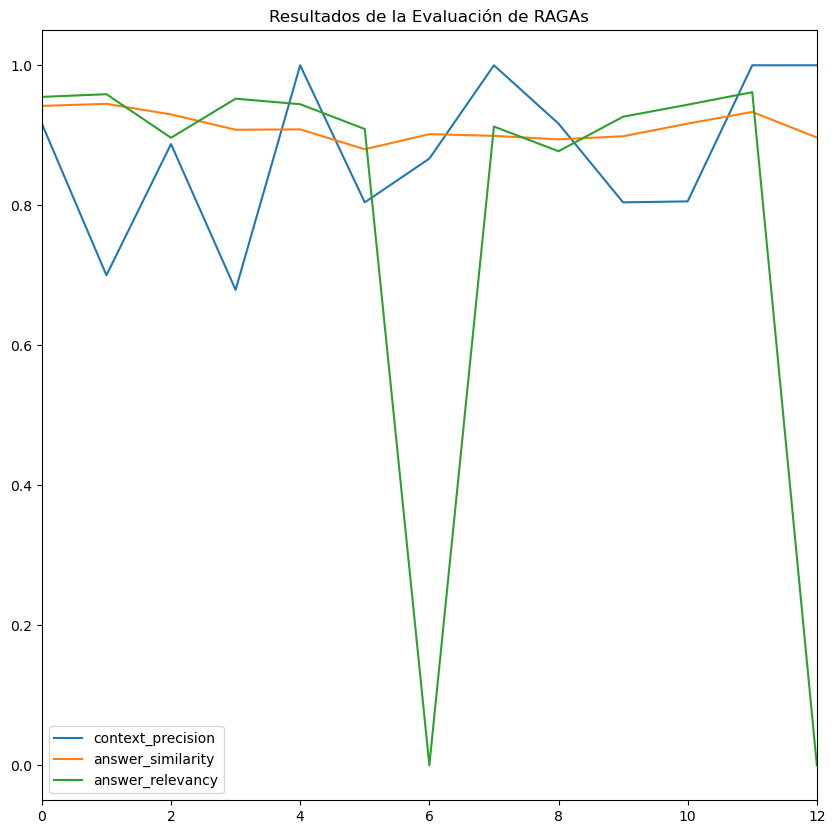

In [25]:
ragas_results_set.plot(
    title='Resultados de la Evaluación de RAGAs',
    figsize=(10,10),
    xlim=(0,12)
)

<Axes: title={'center': 'Resultados de la Evaluación de RAGAs'}>

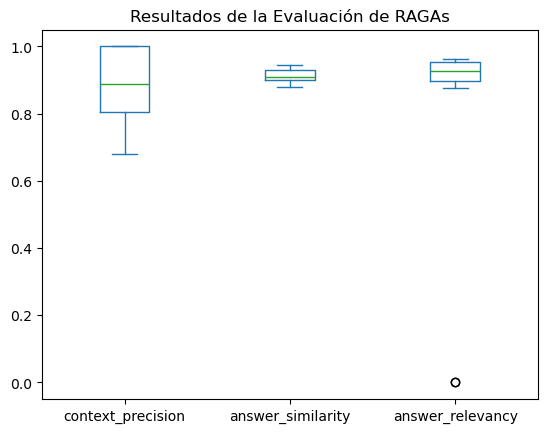

Task exception was never retrieved
future: <Task finished name='Task-424' coro=<AsyncClient.aclose() done, defined at /Users/jcromo/Miniconda3/envs/proyecto/lib/python3.10/site-packages/httpx/_client.py:1967> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/Users/jcromo/Miniconda3/envs/proyecto/lib/python3.10/site-packages/httpx/_client.py", line 1974, in aclose
    await self._transport.aclose()
  File "/Users/jcromo/Miniconda3/envs/proyecto/lib/python3.10/site-packages/httpx/_transports/default.py", line 365, in aclose
    await self._pool.aclose()
  File "/Users/jcromo/Miniconda3/envs/proyecto/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 305, in aclose
    await connection.aclose()
  File "/Users/jcromo/Miniconda3/envs/proyecto/lib/python3.10/site-packages/httpcore/_async/connection.py", line 159, in aclose
    await self._connection.aclose()
  File "/Users/jcromo/Miniconda3/envs/proyecto/lib/python3.10/site-packag

In [26]:
ragas_results_set.plot(
    kind='box',
    title='Resultados de la Evaluación de RAGAs'
)

## **Conclusiones**


La evaluación de modelos generativos con bases de conocimientos para búsqueda referencias está aún en sus etapas iniciales de desarrollo, y aún depende en gran medida de la asistencia de expertos y expertas para validar sus resultados y desempeño. Librerías como RAGAs ayudan tremendamente en la tarea de evaluación, pero requieren que el equipo prepare más datos y respuestas para poder evaluar efectivamente los aspectos de recuperación y generación. 

En los resultados presentados en esta libreta como en la libreta de pruebas de volumen se puede ver que el desempeño del modelo generativo para el proyecto ***Smart Travel Assistant*** ha alcanzado un buen nivel, y aunque se necesitan ajustes adicionales a los datos de la base de conocimiento, la primera versión está casi lista para una prueba interna controlada.

Cabe recalcar que algunas de las métricas evaluadas solo podrán mejorarse una vez que se use el conjunto completo de información de hoteles, ya que actualmente el modelo está usando un subconjunto con hoteles con un nivel de 4 o más estrellas, lo que restringe el universo de datos a un poco más de 145 mil registros.

Los datos de la evaluación se encuentra en el archivo ***hotel-data-set-selected-results.xlsx*** en el mismo repositorio de esta libreta.


## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* AWS. (s.f.). Set up a data source for your knowledge base - Amazon Bedrock. docs.aws.amazon.com. Recuperado 7 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base-ds.html

* AWS. (s.f.). Getting started with model evaluations - Amazon Bedrock. docs.aws.amazon.com. Recuperado 15 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-evaluation-type.html

* AWS. (2023, 28 de noviembre). Knowledge Bases now delivers fully managed RAG experience in Amazon Bedrock - Amazon Web Services.  Amazon Web Services. https://aws.amazon.com/es/blogs/aws/knowledge-bases-now-delivers-fully-managed-rag-experience-in-amazon-bedrock/

* Monigatti, L. (2023, 15 de deciembre). Evaluating RAG Applications with RAGAs. Medium. https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a

* Grech, C. (2024, 16 de febrero). Evaluating RAG Performance: A Comprehensive Guide. Medium. https://christiangrech.medium.com/evaluating-rag-performance-a-comprehensive-guide-b1d8f903b7ad

* AWS (s.f.). Amazon Titan Text models - Amazon Bedrock. docs.aws.amazon.com. Recuperado 20 de mayo 26, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html

* LangChain. (s.f.). Bedrock (Knowledge Bases). python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/retrievers/bedrock/

* LangChain. (s.f.). ChatBedrock. python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/chat/bedrock/

* LangChain. (s.f.). langchain.chains.retrieval_qa.base.RetrievalQA LangChain 0.1.12. api.python.langchain.com. https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html

